# Tutorial: Deep learning with *ewstools*


By the end of this tutorial you should know how to:
- Get bifurcaiton predictions from the DL classifiers trained in the article by [Bury et al. (2021)](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2020.0482)


Total run time : 2 min 18 s on Macbook Air (M1, 2020)

In [1]:
# Start timer to record execution time of notebook
import time
start_time = time.time()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ewstools
from ewstools.models import simulate_ricker

In [3]:
# Tensorflow imports
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # comment out to see TensorFlow warnings 
from tensorflow.keras.models import load_model

## Initialise TimeSeries object

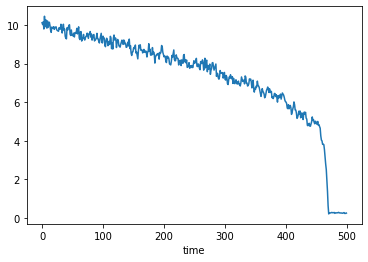

In [6]:
series = simulate_ricker(tmax=500, F=[0,2.7])
series.plot();

In [11]:
ts = ewstools.TimeSeries(series, 440)

## Detrend

In [12]:
ts.detrend(method='Lowess', span=0.2)

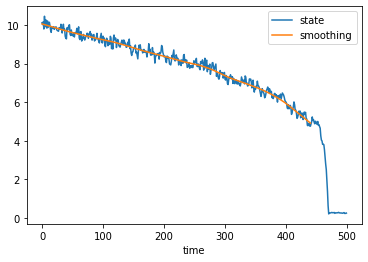

In [13]:
ts.state[['state','smoothing']].plot();

## Compute DL classifier predictions

Deep learning classifiers were recently shown to be effective at predicting upcoming bifurcations and their type [(Bury et al. (2020)](https://www.pnas.org/doi/10.1073/pnas.2106140118). *ewstools* has the functionality to apply these types of classifier to time series data. For methods on how these classifiers are trained, please see the paper.

The method *apply_classifier( )* applies a TensorFlow classifier to the segment of time series data between *tmin* and *tmax* and appends the classification (a vector of probabilites for each class) to *TimeSeries.dl_preds*. The time of the classification is taken as *tmax*. 

Let's import a classifier that was trained in the study by [Bury et al.](https://www.pnas.org/doi/10.1073/pnas.2106140118), and apply it to the Ricker model simulation. For the classifiers in the study, the key is as follows:

| Key | Trajectory |
| :- | :- |
| 0 | fold bifurcation |
| 1 | Hopf bifurcation | 
| 2 | transcritical bifurcation |
| 3 | null |

In [14]:
# Import a classifier
classifier_path = '../saved_classifiers/bury_pnas_21/len500/best_model_1_1_len500.pkl'
classifier = load_model(classifier_path)

Let's apply the classifier to segments of increasing length. Each segment starts at the beginning of the raw time series. Therefore we will take *tmin* to be the start of the time series, and *tmax* to be incrementally larger values up to the transition time.

In [15]:
tmin = ts.state.index[0]
tmax_vals = np.arange(ts.state.index[50], ts.transition, 10)
# Apply the classifier for each value of tmax
for tmax in tmax_vals:
    ts.apply_classifier(classifier, name='c1', tmin=tmin, tmax=tmax, verbose=0)

2022-07-11 09:45:32.147912: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


The attribute *dl_preds* should now contain those predictions:

In [16]:
ts.dl_preds.head()

,0,1,2,3,time,classifier
0,0.421072,0.262330,0.176463,0.140136,50.0,c1
1,0.453313,0.057088,0.206428,0.283171,60.0,c1
2,0.332636,0.025859,0.208425,0.433079,70.0,c1
3,0.356429,0.010360,0.194098,0.439112,80.0,c1
4,0.294667,0.006773,0.167477,0.531084,90.0,c1


Let's visualise those DL predictions:

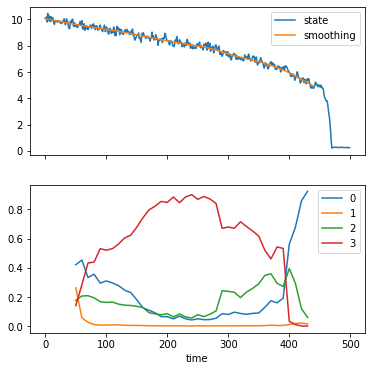

In [17]:
fig1, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,6), sharex=True)
ts.state[['state','smoothing']].plot(ax=axes[0])
ts.dl_preds.set_index('time')[[0,1,2,3]].plot(ax=axes[1],legend=True);

We should find that the DL classification favours the fold bifurcation ('0') as the bifurcation is approached.

#### Ensemble modelling

The previous predictions were obtained from a single classifier. To improve overall performance, we can use ensemble modelling, which involves taking the average of predictions from multiple classifiers. Let's import all 20 classifiers that were trained in the study by [Bury et al.](https://www.pnas.org/doi/10.1073/pnas.2106140118) (the classifiers that were trained on time series with 500 data points).

In [18]:
ts.clear_dl_preds() # we can clear previous DL predictions using this method
root_path = '../saved_classifiers/bury_pnas_21/len500/'
classifier_names = [name for name in os.listdir(root_path) if name[-4:]=='.pkl']

In [19]:
# Takes ~ 2 minutes to run on Macbook Air (M1, 2020)
# Loop through each classifier
for classifier_name in classifier_names:
    # Import classifier
    classifier = load_model(root_path + classifier_name)
    # Get DL predictions - note we can provide a classifier name for reference
    for tmax in tmax_vals:
        ts.apply_classifier(classifier, name=classifier_name, tmin=tmin, tmax=tmax, verbose=0)  
    print('Predictions complete for classifier {}'.format(classifier_name))

Predictions complete for classifier best_model_5_1_len500.pkl


KeyboardInterrupt: 

Now *dl_preds* should contain predictions made from multiple classifiers:

In [26]:
ts.dl_preds['classifier'].unique()

array(['best_model_5_1_len500.pkl', 'best_model_2_1_len500.pkl',
       'best_model_7_2_len500.pkl', 'best_model_6_2_len500.pkl',
       'best_model_1_2_len500.pkl', 'best_model_3_1_len500.pkl',
       'best_model_4_1_len500.pkl', 'best_model_9_1_len500.pkl',
       'best_model_8_1_len500.pkl', 'best_model_10_2_len500.pkl',
       'best_model_10_1_len500.pkl', 'best_model_8_2_len500.pkl',
       'best_model_9_2_len500.pkl', 'best_model_3_2_len500.pkl',
       'best_model_4_2_len500.pkl', 'best_model_6_1_len500.pkl',
       'best_model_1_1_len500.pkl', 'best_model_7_1_len500.pkl',
       'best_model_5_2_len500.pkl', 'best_model_2_2_len500.pkl'],
      dtype=object)

It remains to take the average prediction over all classfiers for each point in time:

In [27]:
df_dl_preds_av = ts.dl_preds.groupby(['time']).mean()
df_dl_preds_av.head()

,0,1,2,3
time,,,,
50.0,0.183030,0.129234,0.190455,0.497281
60.0,0.216371,0.092184,0.212938,0.478507
70.0,0.189128,0.060058,0.197056,0.553758
80.0,0.193775,0.036351,0.194410,0.575465
90.0,0.308015,0.029384,0.277292,0.385309


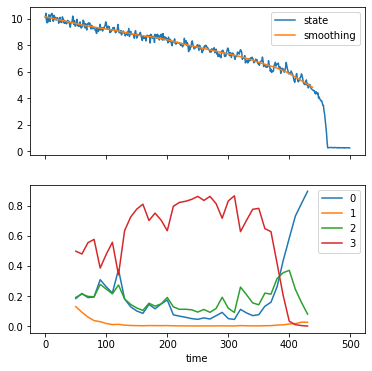

In [28]:
fig1, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,6), sharex=True)
ts.state[['state','smoothing']].plot(ax=axes[0])
df_dl_preds_av.plot(ax=axes[1],legend=True);

That's it! Feel free to copy and play around with this notebook for your own data.

In [29]:
# Stop timer
end_time = time.time()
print('Notebook took {:.1f}s to run'.format(end_time-start_time))

Notebook took 139.4s to run
